<a href="https://colab.research.google.com/github/Natalina04/Ensino-Superior-no-Brasil/blob/main/2020_Machine_Learning_Previs%C3%A3o_de_nota_do_ENEM_RED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FGV EPGE - Escola de Pós-Graduação em Economia
==
Machine Learning
--
Natalina Costa

**Premissa:**
Esse trabalho parte da premissa que fatores socioeconômicos  tem uma relação direta com o desempenho dos alunos no Exame Nacional do Ensino Médio. Dessa forma, nos propomos a mostrar estatisticamente o que o senso comum já nos indica, que alunos sob determinadas condições precisam ser outliers do seu meio para sobressaírem à própria realidade.

**Estruturação:**
Inicialmente foram usados os dados do questionário socioeconômico preenchido pelos alunos no momento da inscrição para o ENEM e comparados com seu desempenho em Redação, verificando a correlação entre cada variável e a partir de então estabelecendo um modelo capaz de predizer o desempenho do aluno.

In [ ]:
#Importando Bibliotecas
import seaborn as sns
from google.colab import drive
import sklearn
#assert sklearn.__version__ >= "0.20"
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import sklearn.linear_model
import os
from google.colab import drive

In [ ]:
#Abrindo arquivo com os dados publicos de educação
drive.mount('/content/Drive')
root_path = '/content/drive/My Drive/"Machine Learning - MFEE"/MICRODADOS_ENEM_2020.csv'
csv_enem = '/content/drive/My Drive/"Machine Learning - MFEE"/MICRODADOS_ENEM_2020.csv'

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


**Tratamento inicial dos dados:**
Inicialmente foram analisadas as colunas da tabela, que tem sua descrição no Dicionário de atributos. Foram excluídas todas as colunas com dados de alunos com necessidades especiais, códigos de cidades e de estados, vetores com o gabarito de cada aluno, códigos de provas, entre outros que são irrelevantes para a análise proposta.
Posteriormente foi realizada a retirada dos dados dos alunos que faltaram a qualquer uma das provas ou que tiraram nota 0.



In [ ]:
csv_enem = pd.read_csv('/content/Drive/MyDrive/MICRODADOS_ENEM_2020.csv', nrows=30, encoding='iso-8859-1', sep=';')
csv_enem.head()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,200006271946,2020,11,F,1,2,1,1,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200001195856,2020,11,M,2,3,1,1,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200001943954,2020,4,F,2,3,2,2,0,2,...,B,A,A,B,A,A,A,A,A,A
3,200001908998,2020,2,M,1,3,1,2,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200001634757,2020,4,F,1,3,2,1,1,1,...,A,A,A,B,A,B,B,A,A,B


In [ ]:
#Retirada de colunas com informações irrelevantes para a análise
cols = csv_enem.columns.values.tolist()
drop_cols = ('IN', 'NU_ANO', 'TX_', 'NO_', 'SG_')
for col in cols[:]:
    if col.startswith(drop_cols):
        cols.remove(col)

csv_enem = pd.read_csv('/content/Drive/MyDrive/MICRODADOS_ENEM_2020.csv', encoding='iso-8859-1', sep=';', usecols=cols)

print('Meu banco de dados agora tem', len(cols), 'colunas e', len(csv_enem.index), 'linhas.' )

Meu banco de dados agora tem 62 colunas e 5783109 linhas.


In [ ]:
# Retirada dos dados de alunos que faltaram a qualquer uma das provas
for col in ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']:
    csv_enem = csv_enem[csv_enem[col] == 1]

print('Meu banco de dados agora tem', len(cols), 'colunas e', len(csv_enem.index), 'linhas.' )

Meu banco de dados agora tem 62 colunas e 2588681 linhas.


In [ ]:
# Eliminando os alunos que tiraram 0 em qualquer uma das provas
for col in ['NU_NOTA_MT', 'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_REDACAO', 'NU_NOTA_LC']:
    csv_enem = csv_enem[csv_enem[col] != 0]

print('Meu banco de dados agora tem', len(cols), 'colunas e', len(csv_enem.index), 'linhas.' )

Meu banco de dados agora tem 62 colunas e 2527394 linhas.


**2 - Análise dos atributos com relação à nota de Redação**
--

A partir de agora vamos analisar a distribuição dos resultados da nota de Redação: e a relação desta com os atributos.

In [ ]:
# Análise da distribuição dos resultados de matemática
notard = 'NU_NOTA_REDACAO'
csv_enem[notard].describe()

count    2.527394e+06
mean     5.949452e+02
std      1.768469e+02
min      4.000000e+01
25%      4.800000e+02
50%      5.800000e+02
75%      7.200000e+02
max      1.000000e+03
Name: NU_NOTA_REDACAO, dtype: float64

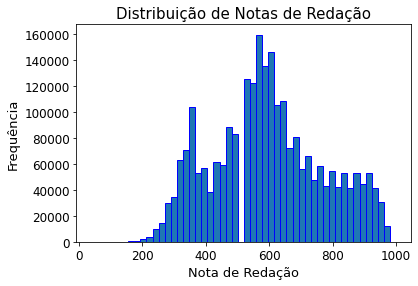

In [ ]:
plt.title('Distribuição de Notas de Redação', fontsize=15)
plt.xlabel('Nota de Redação', fontsize=13)
plt.ylabel('Frequência', fontsize=13)
plt.tick_params(labelsize=12)
plt.hist(csv_enem[notard], 50, rwidth=3, edgecolor='blue')
plt.show()

**2.0 - Situação da Nota de Redação**

Text(0, 0.5, 'Nota de Redação')

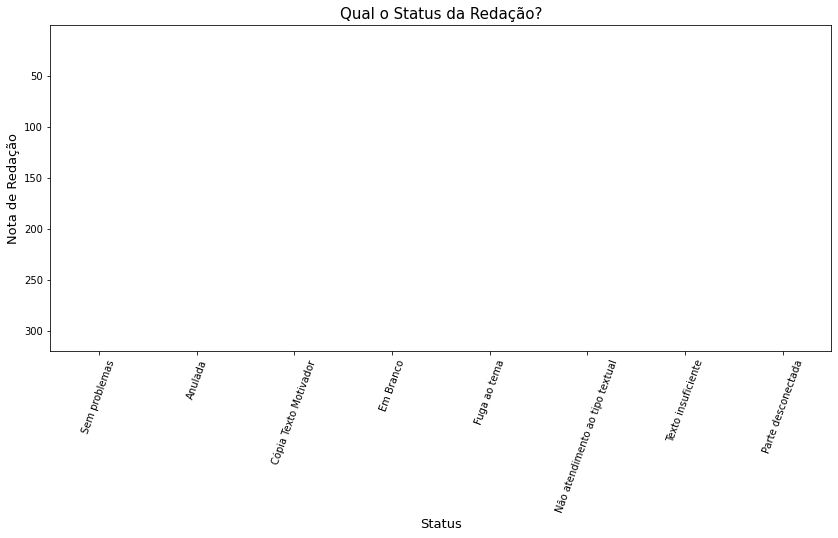

In [ ]:
# Análise da relação Nota de Redação x Situação da Nota
var0 = 'TP_STATUS_REDACAO'
A = 'Sem problemas'
B = 'Anulada'
C = 'Cópia Texto Motivador'
D = 'Em Branco'
E = 'Fuga ao tema'
F = 'Não atendimento ao tipo textual'
G = 'Texto insuficiente'
H = 'Parte desconectada'
plotdata = pd.concat([csv_enem[notard], csv_enem[var0].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F' : F, 'G' : G, 'H': H})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var0, y=csv_enem[notard], data=plotdata, order=[A, B, C, D, E, F, G, H], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
fig.set_title("Qual o Status da Redação?", fontsize=15)
fig.set_xlabel("Status", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**2.1 - Escolaridade do pai vs Nota Redação**

Conforme gráfico abaixo, pode-se observar que a escolaridade do pai tem relação crescente e positiva com a nota de redação, quando maior a escolaridade, maior a nota, pais sem escolaridade possuem a menor nota.

Text(0, 0.5, 'Nota de Redação')

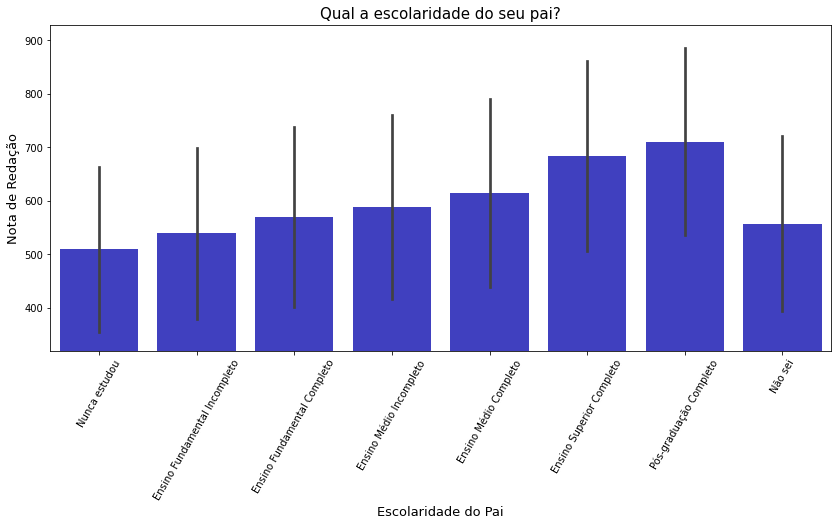

In [ ]:
# Análise da relação Nota de Redação x Escolaridade do Pai
var1 = 'Q001'
A = 'Nunca estudou'
B = 'Ensino Fundamental Incompleto'
C = 'Ensino Fundamental Completo'
D = 'Ensino Médio Incompleto'
E = 'Ensino Médio Completo'
F = 'Ensino Superior Completo'
G = 'Pós-graduação Completo'
H = 'Não sei'
plotdata = pd.concat([csv_enem[notard], csv_enem[var1].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F, 'G': G, 'H': H})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var1, y=csv_enem[notard], data=plotdata, order=[A, B, C, D, E, F, G, H], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
fig.set_title("Qual a escolaridade do seu pai?", fontsize=15)
fig.set_xlabel("Escolaridade do Pai", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**2.2 - Escolaridade da mãe vs Nota Redação**

Conforme gráfico abaixo, pode-se observar que a escolaridade da mãe tem grande influência...

Text(0, 0.5, 'Nota de Redação')

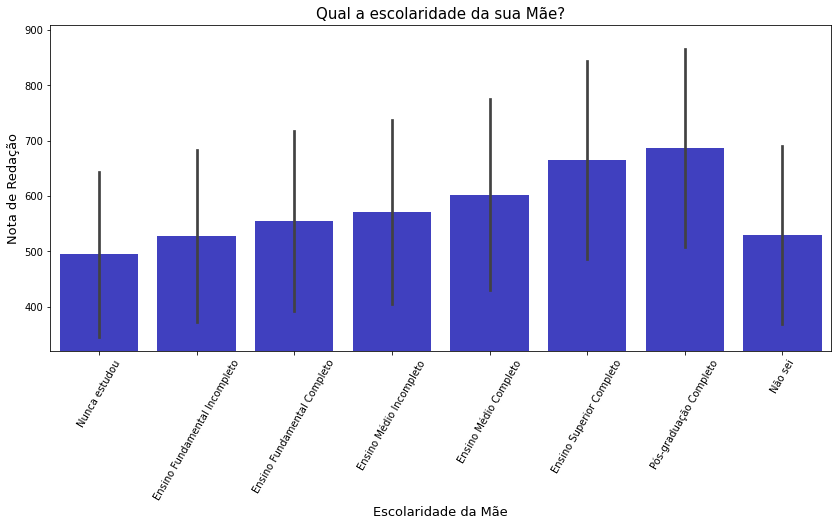

In [ ]:
# Análise da relação Nota de Matemática x Escolaridade da Mãe
var2 = 'Q002'
A = 'Nunca estudou'
B = 'Ensino Fundamental Incompleto'
C = 'Ensino Fundamental Completo'
D = 'Ensino Médio Incompleto'
E = 'Ensino Médio Completo'
F = 'Ensino Superior Completo'
G = 'Pós-graduação Completo'
H = 'Não sei'
plotdata = pd.concat([csv_enem[notard], csv_enem[var2].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F, 'G': G, 'H': H})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var2, y=csv_enem[notard], data=plotdata, order=[A, B, C, D, E, F, G, H], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
fig.set_title("Qual a escolaridade da sua Mãe?", fontsize=15)
fig.set_xlabel("Escolaridade da Mãe", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**2.3 - Ocupação do Pai vs Nota Redação**

Text(0, 0.5, 'Nota de Redação')

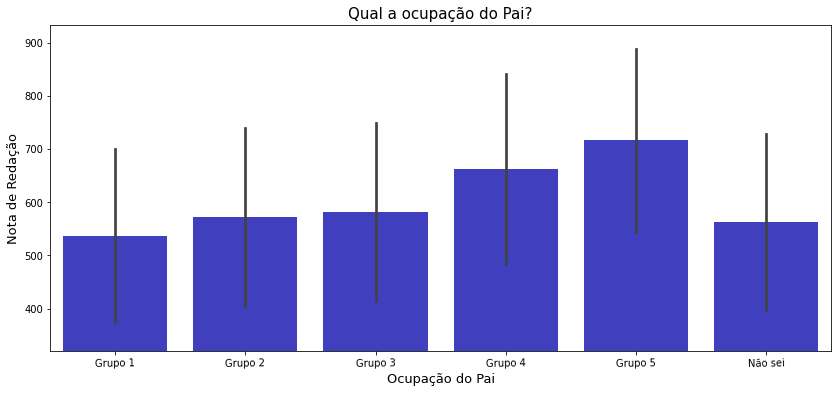

In [ ]:
# Análise da relação Nota de Matemática x Ocupação do Pai
var3 = 'Q003'
A = 'Grupo 1'#Lavrador, agricultor sem empregados'
B = 'Grupo 2' # Diarista, empregado doméstico'
C = 'Grupo 3' #Padeiro, cozinheiro industrial'
D = 'Grupo 4' #Professor, técnico, policial, militar'
E = 'Grupo 5' #Médico, engenheiro, dentista'
F = 'Não sei'
plotdata = pd.concat([csv_enem[notard], csv_enem[var3].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F,})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var3, y=csv_enem[notard], data=plotdata, order=[A, B, C, D, E, F], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=1)
fig.set_title("Qual a ocupação do Pai?", fontsize=15)
fig.set_xlabel("Ocupação do Pai", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**2.4 - Ocupação da Mãe vs Nota Redação**

Text(0, 0.5, 'Nota de Matemática')

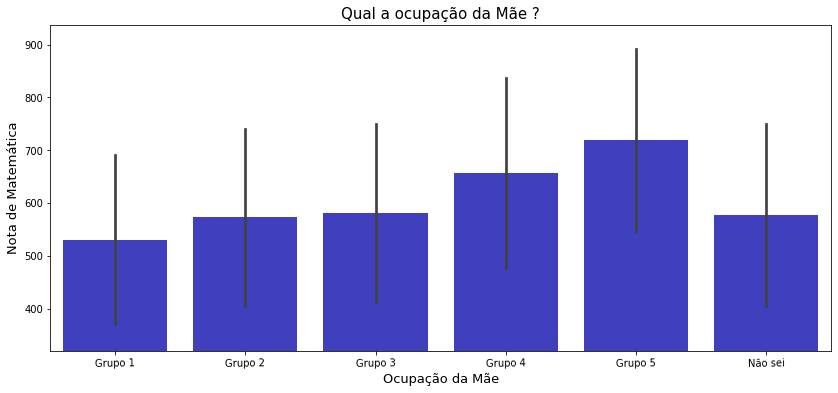

In [ ]:
# Análise da relação Nota de Redação x Ocupação da Mãe
var4 = 'Q004'
A = 'Grupo 1'#Lavrador, agricultor sem empregados'
B = 'Grupo 2' # Diarista, empregado doméstico'
C = 'Grupo 3' #Padeiro, cozinheiro industrial'
D = 'Grupo 4' #Professor, técnico, policial, militar'
E = 'Grupo 5' #Médico, engenheiro, dentista'
F = 'Não sei'
plotdata = pd.concat([csv_enem[notard], csv_enem[var4].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F,})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var4, y=csv_enem[notard], data=plotdata, order=[A, B, C, D, E, F], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=1)
fig.set_title("Qual a ocupação da Mãe ?", fontsize=15)
fig.set_xlabel("Ocupação da Mãe", fontsize=13)
fig.set_ylabel("Nota de Matemática", fontsize=13)

**2.5 - Número de coabitantes vs Nota Nota Redação**

Text(0, 0.5, 'Nota de Redação')

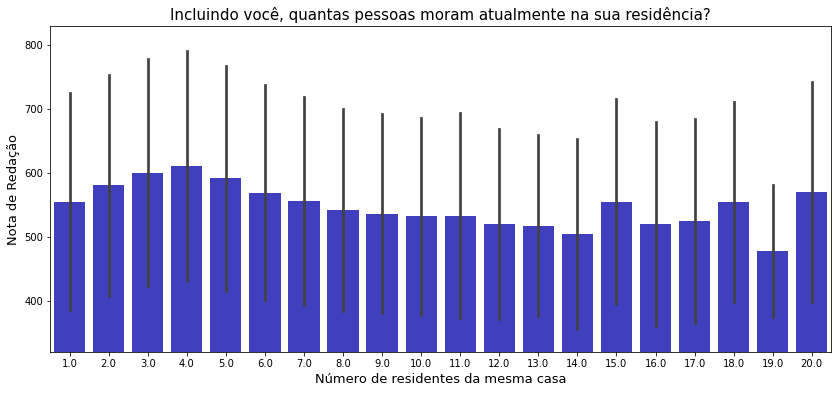

In [ ]:
# Análise da relação Nota de Redação x Número de residentes na mesma casa
var5 = 'Q005'
plotdata = pd.concat([csv_enem[notard], csv_enem[var5]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var5, y=csv_enem[notard], data=plotdata, ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Incluindo você, quantas pessoas moram atualmente na sua residência?", fontsize=15)
fig.set_xlabel("Número de residentes da mesma casa", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

Do gráfico acima, podemos verificar que a Nota é tem influecia relativa pelo número de habitantes na casa do candidato.

**2.6 - Renda Familiar vs Redação**

Text(0, 0.5, 'Nota de Redação')

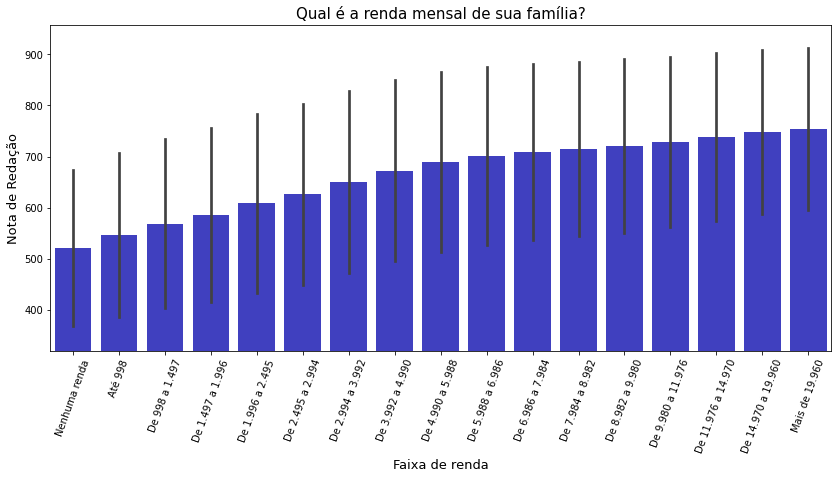

In [ ]:
# Análise da relação Nota de Redação x Renda familiar
var6 = 'Q006'
A = 'Nenhuma renda'
B = 'Até 998'
C = 'De 998 a 1.497'
D = 'De 1.497 a 1.996'
E = 'De 1.996 a 2.495'
F = 'De 2.495 a 2.994'
G = 'De 2.994 a 3.992'
H = 'De 3.992 a 4.990'
I = 'De 4.990 a 5.988'
J = 'De 5.988 a 6.986'
K = 'De 6.986 a 7.984'
L = 'De 7.984 a 8.982'
M = 'De 8.982 a 9.980'
N = 'De 9.980 a 11.976'
O = 'De 11.976 a 14.970'
P = 'De 14.970 a 19.960'
Q = 'Mais de 19.960'
plotdata = pd.concat([csv_enem[notard], csv_enem[var6].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E, 'F': F, 'G': G, 'H': H, 'I': I, 'J': J, 'K': K, 'L': L, 'M': M, 'N': N, 'O': O, 'P': P, 'Q': Q})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var6, y=csv_enem[notard], data=plotdata, order=[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
fig.set_title("Qual é a renda mensal de sua família?", fontsize=15)
fig.set_xlabel("Faixa de renda", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**2.7 - Frequência de empregado(a) doméstico(a) vs Nota Redação**

Text(0, 0.5, 'Nota de Redação')

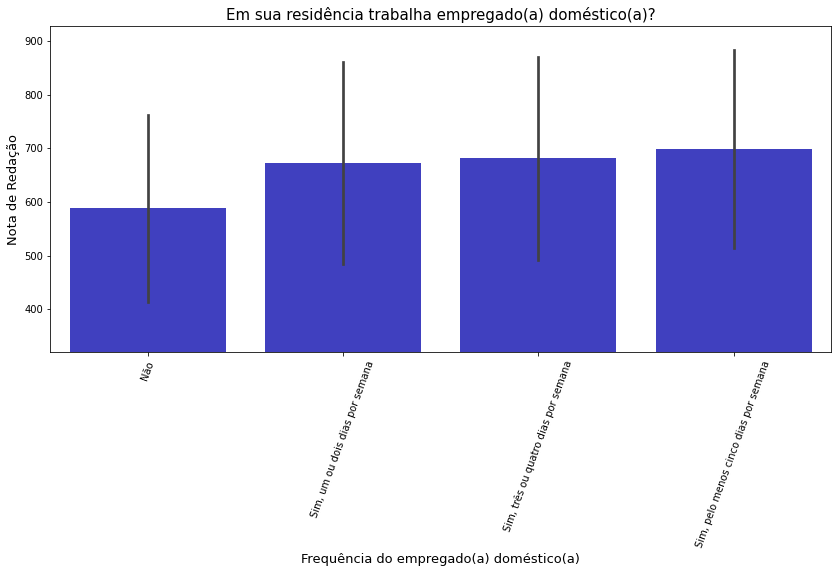

In [ ]:
# Análise da relação Nota de Redação x Empregada doméstica
var7 = 'Q007'
A = 'Não'
B = 'Sim, um ou dois dias por semana'
C = 'Sim, três ou quatro dias por semana'
D = 'Sim, pelo menos cinco dias por semana'
plotdata = pd.concat([csv_enem[notard], csv_enem[var7].map({'A': A, 'B': B, 'C': C, 'D': D})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var7, y=csv_enem[notard], data=plotdata, order=[A, B, C, D], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
fig.set_title("Em sua residência trabalha empregado(a) doméstico(a)?", fontsize=15)
fig.set_xlabel("Frequência do empregado(a) doméstico(a)", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**2.8 - Na sua residência tem carro?**

Text(0, 0.5, 'Nota de Redação')

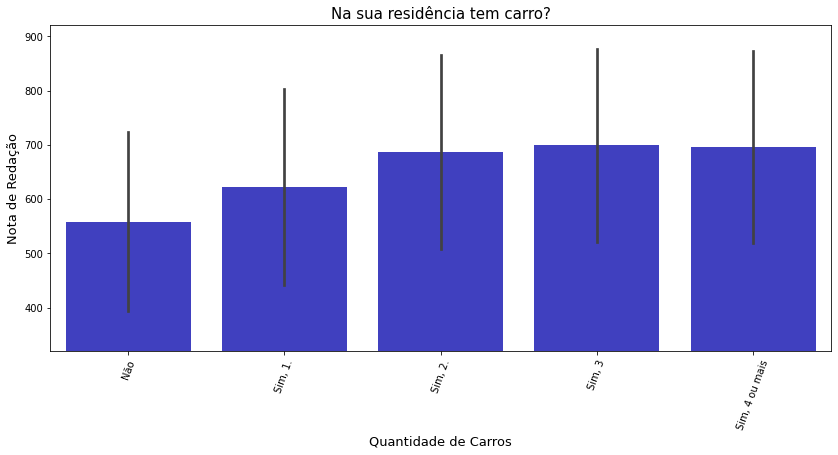

In [ ]:
# Análise da relação Nota de Redação x Quantidade de Carros
var8 = 'Q010'
A = 'Não'
B = 'Sim, 1.'
C = 'Sim, 2.'
D = 'Sim, 3'
E = 'Sim, 4 ou mais'
plotdata = pd.concat([csv_enem[notard], csv_enem[var8].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var8, y=csv_enem[notard], data=plotdata, order=[A, B, C, D, E], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
fig.set_title("Na sua residência tem carro?", fontsize=15)
fig.set_xlabel("Quantidade de Carros", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**2.9 - Na sua residência tem computador?**

In [ ]:
internetaccess = csv_enem['Q025'].value_counts() 
print(internetaccess)
print('Somente', round(394472/(2106432+394472)*100, 2), '% dos alunos declararam não ter acesso à internet em casa.')

B    2106432
A     394472
Name: Q025, dtype: int64
Somente 15.77 % dos alunos declararam não ter acesso à internet em casa.


Text(0, 0.5, 'Nota de Redação')

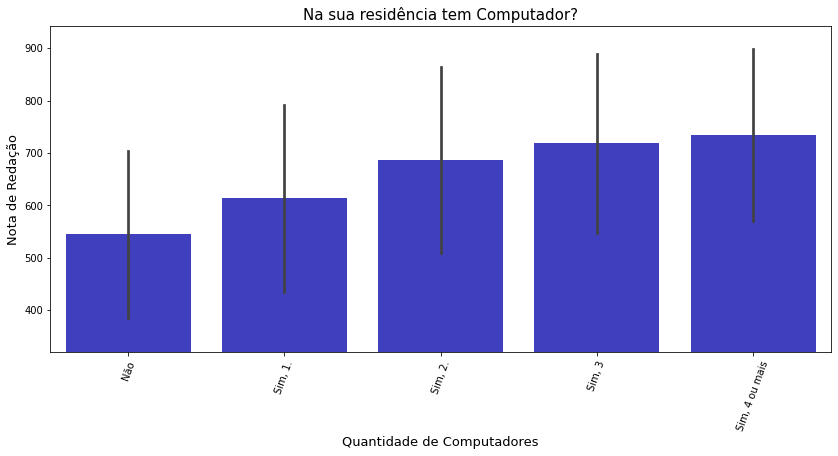

In [ ]:
# Análise da relação Nota de Redação x Televisores
var9 = 'Q024'
A = 'Não'
B = 'Sim, 1.'
C = 'Sim, 2.'
D = 'Sim, 3'
E = 'Sim, 4 ou mais'
plotdata = pd.concat([csv_enem[notard], csv_enem[var9].map({'A': A, 'B': B, 'C': C, 'D': D, 'E': E})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var9, y=csv_enem[notard], data=plotdata, order=[A, B, C, D, E], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=70)
fig.set_title("Na sua residência tem Computador?", fontsize=15)
fig.set_xlabel("Quantidade de Computadores", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**2.10 - Sexo vs Nota de Redação**

Text(0, 0.5, 'Nota de Redação')

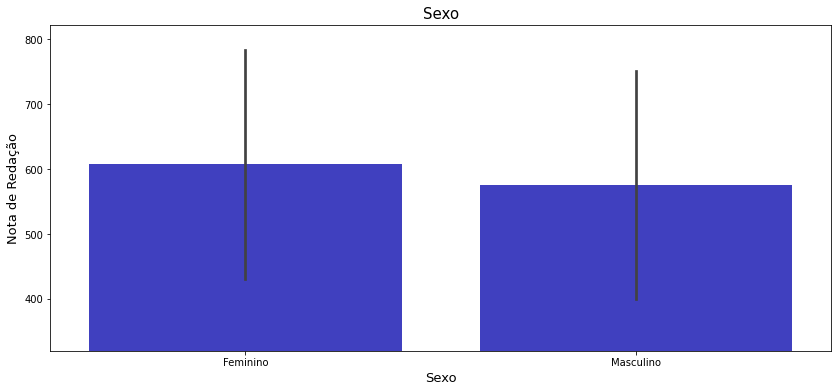

In [ ]:
# Análise da relação Nota de Matemática x Sexo do candidato
var10 = 'TP_SEXO'
M = 'Masculino'
F = 'Feminino'
plotdata = pd.concat([csv_enem[notard], csv_enem[var10].map({'M': M, 'F': F})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var10, y=csv_enem[notard], data=plotdata, order=[F, M], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Sexo", fontsize=15)
fig.set_xlabel("Sexo", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**1.11 - Raça vs Nota de Redação**

Text(0, 0.5, 'Nota de Redação')

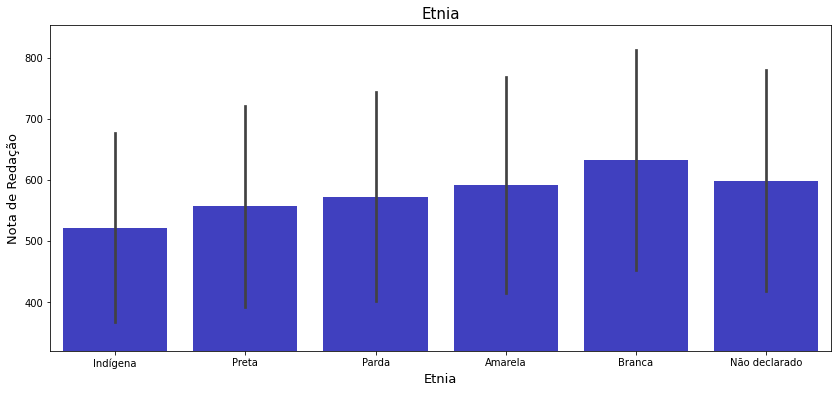

In [ ]:
# Análise da relação Nota de Matemática x Sexo do candidato
var11 = 'TP_COR_RACA'
A = 'Não declarado'
B = 'Branca'
C = 'Preta'
D = 'Parda'
E = 'Amarela'
F = 'Indígena'
plotdata = pd.concat([csv_enem[notard], csv_enem[var11].map({0: A, 1: B, 2: C, 3: D, 4: E, 5: F})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var11, y=csv_enem[notard], data=plotdata, order=[F, C, D, E, B, A], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Etnia", fontsize=15)
fig.set_xlabel("Etnia", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**1.12 - Tipo de escola vs Nota Redação**

Text(0, 0.5, 'Nota de Redação')

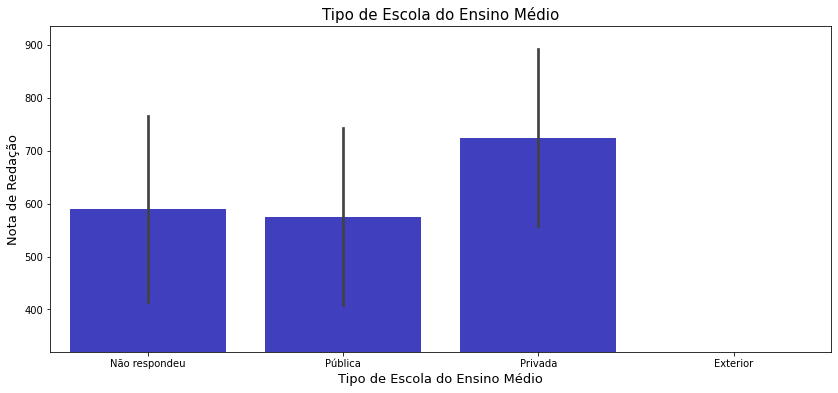

In [ ]:
# Análise da relação Nota de Matemática x Tipo de Escola do Ensino Médio
var12_1 = 'TP_ESCOLA'
A = 'Não respondeu'
B = 'Pública'
C = 'Privada'
D = 'Exterior'

plotdata = pd.concat([csv_enem[notard], csv_enem[var12_1].map({1: A, 2: B, 3: C, 4: D})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var12_1, y=csv_enem[notard], data=plotdata, order=[A, B, C, D], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Tipo de Escola do Ensino Médio", fontsize=15)
fig.set_xlabel("Tipo de Escola do Ensino Médio", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

In [ ]:
kindschool = csv_enem['TP_ESCOLA'].value_counts() 
print(kindschool)
csv_enem['TP_ESCOLA'].isnull().values.sum()
print('Nós temos', kindschool[1], 'missing values no atributo que define o tipo de escola de conclusão do ensino médio.')

1    1733888
2     631189
3     162317
Name: TP_ESCOLA, dtype: int64
Nós temos 1733888 missing values no atributo que define o tipo de escola de conclusão do ensino médio.


Text(0, 0.5, 'Nota de Redação')

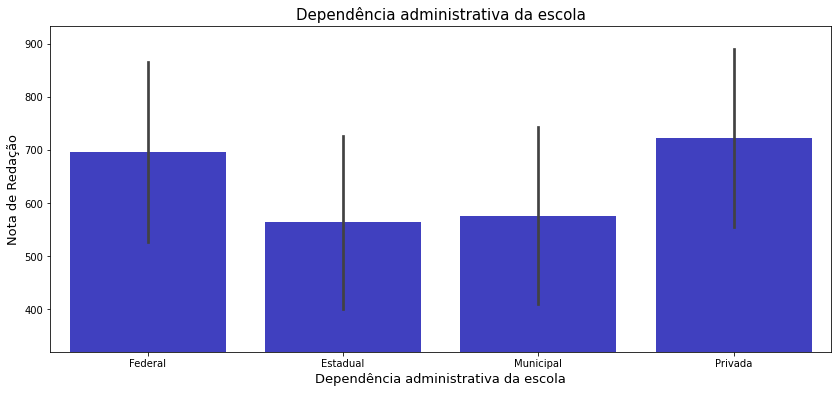

In [ ]:
# Análise da relação Nota de Matemática x Dependência administrativa da escola
var12_2 = 'TP_DEPENDENCIA_ADM_ESC'
A = 'Federal'
B = 'Estadual'
C = 'Municipal'
D = 'Privada'

plotdata = pd.concat([csv_enem[notard], csv_enem[var12_2].map({1: A, 2: B, 3: C, 4: D})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var12_2, y=csv_enem[notard], data=plotdata, order=[A, B, C, D], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Dependência administrativa da escola", fontsize=15)
fig.set_xlabel("Dependência administrativa da escola", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

In [ ]:
kindschool_2 = csv_enem['TP_DEPENDENCIA_ADM_ESC'].value_counts() 
print(kindschool_2)
print('Nós temos', csv_enem['TP_DEPENDENCIA_ADM_ESC'].isnull().values.sum(), 'missing values no atributo que define a dependência administrativa da escola.')

2.0    308368
4.0    175431
1.0     37579
3.0      4043
Name: TP_DEPENDENCIA_ADM_ESC, dtype: int64
Nós temos 2001973 missing values no atributo que define a dependência administrativa da escola.


**1.13 - Localização da Escola vs Nota Redação**

In [ ]:
localizationschool = csv_enem['CO_UF_ESC'].value_counts() 
print(localizationschool)
print('Nós temos', csv_enem['CO_UF_ESC'].isnull().values.sum(), 'missing values no atributo que define a localização da escola.')

35.0    97083
23.0    49546
31.0    46320
33.0    39820
29.0    31112
26.0    26787
41.0    26510
43.0    22745
15.0    20482
52.0    19549
21.0    15551
42.0    15387
53.0    14104
25.0    13348
32.0    11850
22.0    10598
24.0    10362
13.0    10318
27.0     8561
51.0     8480
50.0     6798
28.0     6469
11.0     4087
17.0     3926
12.0     2321
16.0     2064
14.0     1243
Name: CO_UF_ESC, dtype: int64
Nós temos 2001973 missing values no atributo que define a localização da escola.


Text(0, 0.5, 'Nota de Redação')

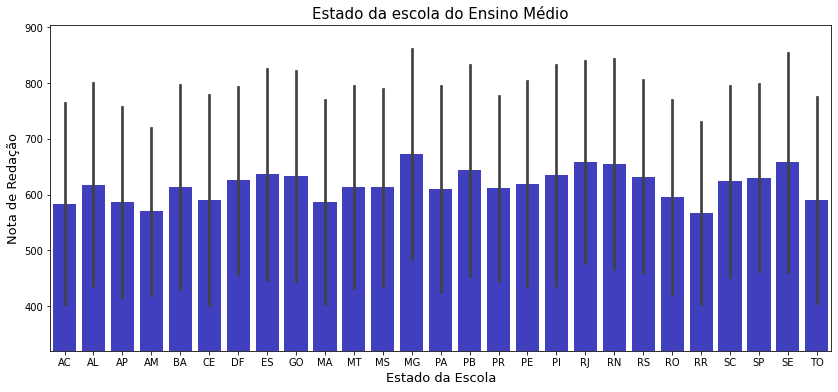

In [ ]:
# Análise da relação Nota de Redação x Estado da escola onde concluiu o Ensino Médio 
var13_1 = 'CO_UF_ESC'
A = 'AC'
B = 'AL'
C = 'AP'
D = 'AM'
E = 'BA'
F = 'CE'
G = 'DF'
H = 'ES'
I = 'GO'
J = 'MA'
K = 'MT'
L = 'MS'
M = 'MG'
N = 'PA'
O = 'PB'
P = 'PR'
Q = 'PE'
R = 'PI'
S = 'RJ'
T = 'RN'
U = 'RS'
V = 'RO'
W = 'RR'
X = 'SC'
Y = 'SP'
Z = 'SE'
AA = 'TO'

plotdata = pd.concat([csv_enem[notard], csv_enem[var13_1].map({12: A, 27: B, 16: C, 13:D, 29: E, 23: F, 53: G, 32: H, 52: I, 21: J, 51: K, 50: L, 31: M, 15: N, 25: O, 41: P, 26: Q, 22: R, 33: S, 24: T, 43: U, 11: V, 14: W, 42: X, 35: Y, 28: Z, 17: AA})], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.barplot(x=var13_1, y=csv_enem[notard], data=plotdata, order=[A, B, C, D, E ,F ,G , H, I,J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, AA], ci='sd', color='blue', saturation=.5)
fig.axis(ymin=320);
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
fig.set_title("Estado da escola do Ensino Médio", fontsize=15)
fig.set_xlabel("Estado da Escola", fontsize=13)
fig.set_ylabel("Nota de Redação", fontsize=13)

**3 - Tratamento de Dados**
--
*texto em itálico*

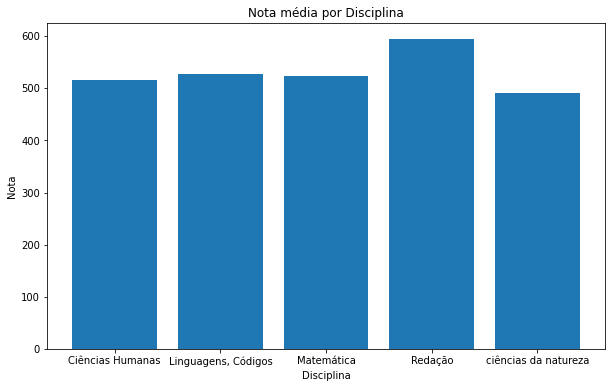

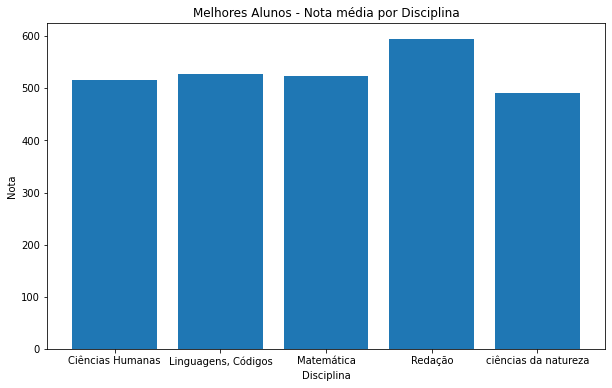

In [ ]:
notas_medias = {'ciências da natureza': np.mean(csv_enem['NU_NOTA_CN']),
'Ciências Humanas':np.mean(csv_enem['NU_NOTA_CH']),
'Linguagens, Códigos':np.mean(csv_enem['NU_NOTA_LC']),
'Matemática':np.mean(csv_enem['NU_NOTA_MT']),
'Redação':np.mean(csv_enem['NU_NOTA_REDACAO'])}
lists = sorted(notas_medias.items()) 

x1, y1 = zip(*lists) 
plt.figure(figsize=(10,6))

plt.bar(x1, y1)
plt.title('Nota média por Disciplina')
plt.xlabel('Disciplina')
plt.ylabel('Nota')
plt.show()

notas_medias_melhores = {'ciências da natureza': np.mean(csv_enem['NU_NOTA_CN']),
'Ciências Humanas':np.mean(csv_enem['NU_NOTA_CH']),
'Linguagens, Códigos':np.mean(csv_enem['NU_NOTA_LC']),
'Matemática':np.mean(csv_enem['NU_NOTA_MT']),
'Redação':np.mean(csv_enem['NU_NOTA_REDACAO'])}
lists = sorted(notas_medias.items()) 

lists = sorted(notas_medias_melhores.items())

x2, y2 = zip(*lists)
plt.figure(figsize=(10,6))

plt.bar(x2, y2)
plt.title('Melhores Alunos - Nota média por Disciplina')
plt.xlabel('Disciplina')
plt.ylabel('Nota')
plt.show()

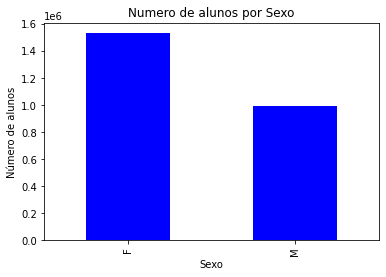

In [ ]:
#numero por Sexo
csv_enem_TP_SEXO = pd.Series(csv_enem.TP_SEXO, dtype='category').cat.rename_categories({2:'F', 1:'M'})
csv_enem_TP_SEXO.value_counts().plot.bar(color='blue')
plt.title('Numero de alunos por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Número de alunos')
plt.show()

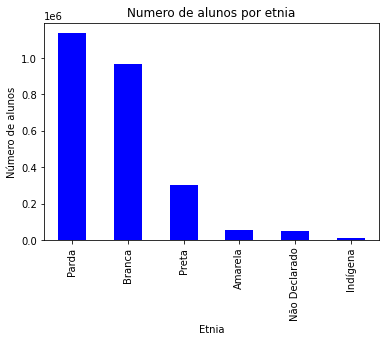

In [ ]:
#numero por Sexo
csv_enem_TP_COR_RACA = pd.Series(csv_enem.TP_COR_RACA, dtype='category').cat.rename_categories({3:'Parda', 2:'Preta', 1:'Branca', 0:'Não Declarado', 4:'Amarela', 5:'Indígena', 6:'Não dispor'})
csv_enem_TP_COR_RACA.value_counts().plot.bar(color='blue')
plt.title('Numero de alunos por etnia')
plt.xlabel('Etnia')
plt.ylabel('Número de alunos')
plt.show()

In [ ]:
# Cria nota média
csv_enem['NOTA_MEDIA'] = (csv_enem['NU_NOTA_CN'] + csv_enem['NU_NOTA_CH'] + csv_enem['NU_NOTA_LC'] + csv_enem['NU_NOTA_MT'] + 
    csv_enem['NU_NOTA_REDACAO']) / 5.0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Nota Média')

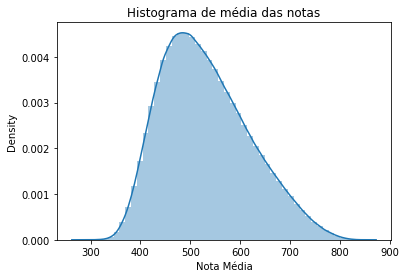

In [ ]:
# Histograma das médias

plt.axes(sns.distplot(csv_enem.NOTA_MEDIA))
plt.title('Histograma de média das notas')
plt.xlabel('Nota Média')

## 3 - Missing Data##

É importante fazer o tratamento de missing data antes de treinarmos qualquer modelo. Isso porque podemos ter, em nosso dataset, informações nulas ou qualquer outro tipo de valor não aceito pelo modelo utilizado, o que impediria o treinamento.

No início, eliminando os estudantes que faltaram o ENEM, e todos aqueles que ficaram com nota 0. Agora vamos verificar se temos algum missing data em nossas features.

In [ ]:
cols_candidatos = ['NU_INSCRICAO', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004','Q005', 'Q006', 'Q007', 'Q010', 'Q024', 'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC', 'CO_UF_ESC']

#missing data
model_data = csv_enem[cols_candidatos]

total = model_data.isnull().sum().sort_values(ascending=False)
print('missing data:\n', total)

missing data:
 TP_DEPENDENCIA_ADM_ESC    2001973
CO_UF_ESC                 2001973
Q001                        26490
Q002                        26490
Q003                        26490
Q004                        26490
Q005                        26490
Q006                        26490
Q007                        26490
Q010                        26490
Q024                        26490
NU_INSCRICAO                    0
NU_NOTA_REDACAO                 0
TP_SEXO                         0
TP_COR_RACA                     0
TP_ESCOLA                       0
dtype: int64


In [ ]:
situationstudent = csv_enem['TP_ST_CONCLUSAO'].value_counts() 
print(situationstudent)
print('Nós temos', csv_enem['TP_ST_CONCLUSAO'].isnull().values.sum(), 'missing values no atributo que define a residência do aluno.')

1    1391768
2     793506
3     335658
4       6462
Name: TP_ST_CONCLUSAO, dtype: int64
Nós temos 0 missing values no atributo que define a residência do aluno.


In [ ]:
total = len(model_data.index)

#str(round(percent,1)) +'%'

r1 = model_data[(model_data['Q002'] == 'H') & (model_data['Q001'] == 'H')]['Q002'].count()
r1_percent = ' ('+str(round(r1*100/total,1))+'%)'
print('respondentes que não sabem a escolaridade da mãe nem do pai: '+ str(r1)+r1_percent)

r0 = model_data[(model_data['Q002'] == 'H') | (model_data['Q001'] == 'H')]['Q002'].count() - 2*r1
r0_percent = ' ('+str(round(r0*100/total,1))+'%)'
print('respondentes que não sabem a escolaridade da mãe mas sabem do pai, ou vice versa: '+str(r0)+r0_percent)

r2 = model_data[(model_data['Q004'] == 'F') & (model_data['Q003'] == 'F')]['Q002'].count()
r2_percent = ' ('+str(round(r2*100/total,1))+'%)'
print('\nrespondentes que não sabem a ocupação da mãe nem do pai: '+ str(r2)+r2_percent)

#r3 = model_data[((model_data['Q002'] == 'H') & (data['Q001'] == 'H') & (model_data['Q004'] == 'F') & (data['Q003'] == 'F'))]['Q002'].count()
#print('\nunião entre os grupos acima: ', r1+r2-r3)

r4 = model_data[(model_data['TP_COR_RACA'] == 0)]['Q002'].count()
r4_percent = ' ('+str(round(r4*100/total,1))+'%)'
print('\nrespondentes que não declararam raça: '+ str(r4)+r4_percent)

respondentes que não sabem a escolaridade da mãe nem do pai: 35675 (1.4%)
respondentes que não sabem a escolaridade da mãe mas sabem do pai, ou vice versa: 139519 (5.5%)

respondentes que não sabem a ocupação da mãe nem do pai: 67945 (2.7%)

respondentes que não declararam raça: 47888 (1.9%)


In [ ]:
#Eliminando candidatos que nao sabem a escolaridade do pai nem da mae

model_data2 = model_data[(model_data['Q002'] != 'H') | (model_data['Q001'] != 'H')]
print('Meu banco de dados agora tem', len(cols), 'colunas e', len(model_data2.index), 'linhas.' )

# Agora eliminamos as colunas da ocupação profissional dos pais e do tipo de escola.

cols = ['NU_INSCRICAO', 'NU_NOTA_REDACAO', 'Q001', 'Q002','Q005', 'Q006', 'Q007', 'Q010', 'Q024', 'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC', 'CO_UF_ESC']

model_data3 = model_data2[cols]

Meu banco de dados agora tem 15 colunas e 2491719 linhas.


In [ ]:
model_data3_labels = model_data3.copy()

#feature eng 1: max_escol
#primeiro vamos mapear os níveis de escolaridade A, ..., G, H em números. Como H = "não sei", colocaremos como -1
model_data3_labels['Q001'] = model_data3_labels['Q001'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H':-1})
model_data3_labels['Q002'] = model_data3_labels['Q002'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H':-1})
#agora vamos criar uma coluna que é a maior escolaridade entre pai e mae
model_data3_labels['max_escol'] = model_data3_labels[['Q001', 'Q002']].max(axis=1)
#e jogar fora as duas colunas originais de escolaridade do pai e da mãe
model_data3_labels.drop(['Q001', 'Q002', 'TP_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC', 'CO_UF_ESC'], axis=1, inplace=True)

model_data3_labels['TP_SEXO'] = model_data3_labels['TP_SEXO'].map({'M': 0, 'F': 1})

model_data3_labels['Q006'] = model_data3_labels['Q006'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H':7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16})

model_data3_labels['Q007'] = model_data3_labels['Q007'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3})

model_data3_labels['Q010'] = model_data3_labels['Q010'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4})

model_data3_labels['Q024'] = model_data3_labels['Q024'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4})


model_data3_labels.head()

,NU_INSCRICAO,NU_NOTA_REDACAO,Q005,Q006,Q007,Q010,Q024,TP_SEXO,TP_COR_RACA,max_escol
1,200001195856,580.0,NaN,NaN,NaN,NaN,NaN,0,3,NaN
3,200001908998,760.0,NaN,NaN,NaN,NaN,NaN,0,3,NaN
5,200003132410,700.0,5.0,2.0,0.0,0.0,1.0,1,3,2.0
7,200001334237,600.0,NaN,NaN,NaN,NaN,NaN,0,1,NaN
8,200006762554,600.0,2.0,1.0,0.0,0.0,0.0,1,3,2.0


Conjunto Teste

In [ ]:
y = model_data2['NU_NOTA_REDACAO']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(model_data3_labels, y, test_size=0.2, random_state=42)

Regressão

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(model_data3_labels, y)

In [ ]:
from sklearn.metrics import mean_squared_error
math_predictions = lin_reg.predict(model_data3_labels)
lin_mse = mean_squared_error(y, math_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(model_data3_labels, y)